# Polynomial Regression

In [2]:
import numpy as np
rng = np.random.default_rng()

from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt, rcParams
%matplotlib inline

This notebook is based on [notebook I](https://physics.bu.edu/~pankajm//ML-Notebooks/HTML/NB1_CII-ML_is_difficult.html) of [A High-bias, low-variance introduction to Machine Learning for Physicists](https://physics.bu.edu/~pankajm/ML-Notebooks/MLnotebooks.html).

This notebook focuses on polynomial regression in 1 dimension, for the sake of exploring the challenges of fitting vs prediction in learning problems.

### Bias and Variance

The difficulties of fitting models to training data is well-known. A model with higher complexity (which often means more parameters) can give a better fit, but is at risk of overfitting to noise in the data. The same issues with fitting are amplified and extended when it comes to prediction/learning. 

In learning problems, the relation between model complexity and overfitting is formalized as the [Bias-Variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

Suppose that we were to take a very large dataset, and consider all possible subsets of a particular size over which we could train our models to learn the functional form of the data. In this notebook we will approximate this effect by generating more random samples from the same probability distribution (effectively infinite data).

The bias error is an error that expresses the deviation of the model's prediction for a given input from the true output, averaged across all possible predictions that could be obtained using this exact model trained on different data subsets. This bias represents the extent to which the model is fundamentally incompatible with the underlying data, often caused by not being a complex enough model. High bias can cause the model to miss important relations between features and outputs. This is underfitting.

The variance is an error that expresses the deviation of the model's prediction for a given input from the average prediction for that input across all possible data subsets. In other words, it expresses the statistical variance of the model's prediction. This variance represents the extent to which the model is sensitive to small fluctuations in the training set. A complex model takes more data into consideration, and it starts fitting to meaningless noise. When the training set is changed by even a small amount, the high-variance model will "move" more to capture the change in data, even if that change is just noise. This is overfitting.

This notebook will explore the various consequences of bias and variance, and how they relate to model complexity, sizes of the training data set, and noisiness of the data.

### Notebook Methods

This notebook uses three examples of models: A linear model $\hat{f}(x;a) = ax$, a cubic model $\hat{f}(x;a_1,a_2,a_3) = a_3 x^3 + a_2 x^2 + a_1 x$, and a tenth order model $\hat{f}(x;a_i) = \sum_{i=1}^{10} a_i x^i$. 

These models will be applied to data that is generated as $y = f(x) + \epsilon$, where $\epsilon$ is an i.i.d. variable with zero mean and variance $\sigma$. The function $f(x)$ will be one of three example cases: a linear function $f(x) = 2x$, a cubic function $f(x) = 2x - 5x^3$, or a tenth order function $f(x) = 2x - 10x^5 + 15x^{10}$. 

Performance of each model at fitting to the training data and predicting the testing data will be evaluated with a [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) R^2 - a score closer to 1 indicates better fit/prediction, and the score can go arbitrarily negative. We will not care very much about the exact values of R^2, instead we will focus on the differences between R^2 scores as we vary parameters such as training set size and data noisiness. 

### Training Code

This code defines a few convenience methods for generating training sets and making predictions.

In [65]:
# Generates training data according to underlying linear features.
# ie a true function of the form y = 2x + \epsilon.
# sigma: stdev of the noise variable \epsilon.
def linear_features(sigma, x):
    # Draw Gaussian random noise
    s = sigma*rng.standard_normal(x.size)
    return 2*x + s

# A true cubic function of the form y = 2x - 5x^3 + \epsilon.
def cubic_features(sigma, x):
    s = sigma*rng.standard_normal(x.size)
    return 2*x - 5*x**3 + s

# A true tenth-order function of the form y = 2x - 10x^5 + 15x^10 + \epsilon
def tenth_features(sigma, x):
    s = sigma*rng.standard_normal(x.size)
    return 2*x - 10*x**5 + 15*x**10 + s

# Returns y_pred
def train_linear(X_train,y_train):
    # Train a linear model using the training set
    clf = linear_model.LinearRegression()
    clf.fit(X_train, y_train)
    # Use the linear model to predict y values
    return clf


# Returns y_pred
# n: polynomial degree
def train_poly(n,X_train,y_train):
    polyn = PolynomialFeatures(degree=n)
    # Preprocess into [x_i] -> [1,x_i,x_i^2,...]
    X = polyn.fit_transform(X_train)
    clfn = linear_model.LinearRegression()
    clfn.fit(X,y_train)
    return polyn, clfn

In [53]:
# model_class: 0 = linear, 1 = cubic, 2 = tenth.
# Defaults to linear for ill-defined inputs.
def test_model(model_class, N_train, sigma, x_train_min, x_train_max, x_test_min, x_test_max):
    N_fit = 200
    N_pred = 200
    N_test = 100
    
    # The ranges over which to plot curves
    x_fit_min = x_train_min - 0.05
    x_fit_max = x_train_max + 0.05
    x_pred_min = x_test_min - 0.05
    x_pred_max = x_test_max + 0.05

    x_fit = np.linspace(x_train_min,x_train_max,N_fit)
    x_test = rng.uniform(x_test_min,x_test_max,N_test)
    x_pred = np.linspace(x_test_min,x_test_max,N_pred)
    x_train = rng.uniform(x_train_min,x_train_max,N_train)

    # y values corresponding to training and test sets
    if model_class == 1: # cubic
        y_train = cubic_features(sigma, x_train)
        y_test = cubic_features(sigma, x_test)
        model_class = "Cubic"
    elif model_class == 2: # tenth
        y_train = tenth_features(sigma, x_train)
        y_test = tenth_features(sigma, x_test)
        model_class = "Tenth"
    else: # linear
        y_train = linear_features(sigma, x_train)
        y_test = linear_features(sigma, x_test)
        model_class = "Linear"

    X_fit = x_fit[:, np.newaxis]
    X_pred = x_pred[:, np.newaxis]
    X_train = x_train[:, np.newaxis]
    X_test = x_test[:, np.newaxis]
    
    clf = train_linear(X_train, y_train)
    poly3, clf3 = train_poly(3, X_train, y_train)
    poly10, clf10 = train_poly(10, X_train, y_train)

    # Line of best fit to be displayed over the training set.
    y_fit_linear = clf.predict(X_fit)
    y_fit_3 = clf3.predict(poly3.fit_transform(X_fit))
    y_fit_10 = clf10.predict(poly10.fit_transform(X_fit))

    # Evaluation of fit against training data.
    fit_score_linear = clf.score(X_train, y_train)
    fit_score_3 = clf3.score(poly3.fit_transform(X_train), y_train)
    fit_score_10 = clf10.score(poly10.fit_transform(X_train), y_train)

    # Prediction line to be displayed over the test set.
    y_pred_linear = clf.predict(X_pred)
    y_pred_3 = clf3.predict(poly3.fit_transform(X_pred))
    y_pred_10 = clf10.predict(poly10.fit_transform(X_pred))

    # Evaluation of prediction against testing data.
    pred_score_linear = clf.score(X_test, y_test)
    pred_score_3 = clf3.score(poly3.fit_transform(X_test), y_test)
    pred_score_10 = clf10.score(poly10.fit_transform(X_test), y_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))

    axes[0].plot(x_train, y_train, "o", ms=8, alpha=0.5, label='Training Set')
    axes[1].plot(x_test, y_test, "o", ms=8, alpha=0.5, label='Test Set')

    axes[0].plot(x_fit, y_fit_linear, label=f'Linear: R^2 = {fit_score_linear:.2f}')
    axes[0].plot(x_fit, y_fit_3, label=f'Cubic: R^2 = {fit_score_3:.2f}')
    axes[0].plot(x_fit, y_fit_10, label=f'Tenth Order: R^2 = {fit_score_10:.2f}')

    axes[1].plot(x_pred, y_pred_linear, label=f'Linear: R^2 = {pred_score_linear:.2f}')
    axes[1].plot(x_pred, y_pred_3, label=f'Cubic: R^2 = {pred_score_3:.2f}')
    axes[1].plot(x_pred, y_pred_10, label=f'Tenth: R^2 = {pred_score_10:.2f}')

    # Plot the boundaries of the training set
    axes[0].axvline(x_train_min, linestyle=":", alpha=0.5)
    axes[0].axvline(x_train_max, linestyle=":", alpha=0.5)
    axes[1].axvline(x_train_min, linestyle=":", alpha=0.5)
    axes[1].axvline(x_train_max, linestyle=":", alpha=0.5)

    axes[0].legend(loc='best')
    axes[1].legend(loc='best')

    y_train_max = np.max(y_train)
    y_train_min = np.min(y_train)
    y_test_max = np.max(y_test)
    y_test_min = np.min(y_test)
    #y_max = np.max(y_train)
    #y_min = np.min(y_train)
    
    
    axes[0].set_ylim([1.5*y_train_min,1.5*y_train_max])
    axes[1].set_ylim([1.5*y_test_min,1.5*y_test_max]) 
    axes[0].set_xlim([x_fit_min,x_fit_max])
    axes[1].set_xlim([x_pred_min,x_pred_max])
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    Title="%s data: N=%i, $\\sigma=%.2f$"%(model_class,N_train,sigma)
    plt.suptitle(Title)
    axes[0].set_title("Fit")
    axes[1].set_title("Prediction")

    plt.tight_layout()
    plt.show()

# 0. Sample Output

Each example will contain a pair of graphs generated by the code in the previous section. 

The code is called with a function test_model() that has the following inputs:
- model_class: Integer with 3 cases: 0 sets the linear function, 1 sets the cubic function, 2 sets the tenth order function to be used to generate data for the problem.  
- N_train: Integer, defines the number of data points used for training each model.
- sigma: Float, defines the variance of the noise variable of the data.
- train_min, train_max: Floats, defines the range over which to generate data for training.
- test_min, test_max: Floats, defines the range over which to generate data for prediction.

This function outputs two graphs, one showing the results of fitting and the other showing the results of prediction.

The graph on the left displays the training data and the results of training each model on this data using regression. The R^2 performance of each model is printed in the legend. This is the performance of each model at fitting to the training data.

The graph on the right displays the testing data and the results of each model at predicting the values of the testing data. The curves in this graph are the same as the curves in the other graph. The R^2 performances in this graph are the performances of each model at predicting the values of the testing data. The testing data may have a larger range than the training data, so vertical lines are included to show the boundaries of the training data. 

Usually it will only be important to compare fit results to other fit results, and prediction results to other prediction results. 

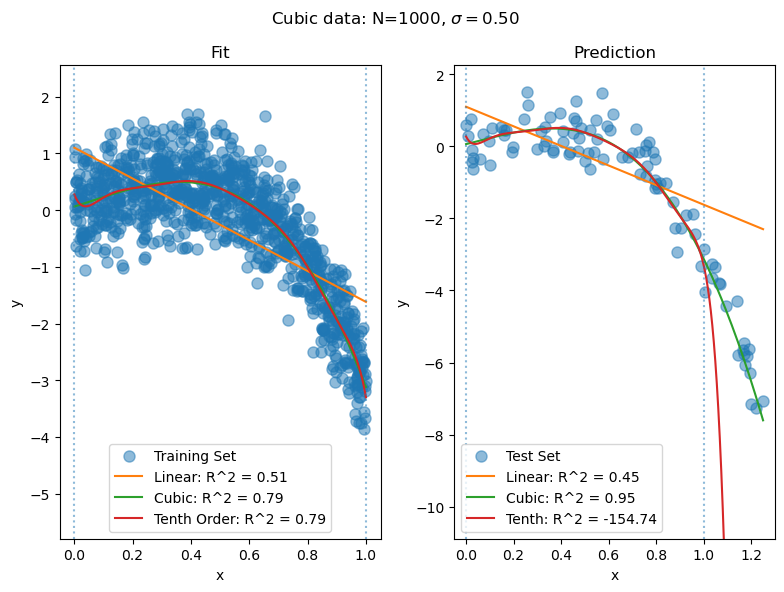

In [54]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(1, 1000, 0.5, 0, 1, 0, 1.25)

# 1. Generalization: Predictions inside and outside the training set

These examples show the results of applying models to make predictions on data both inside and outside the training set's range. This will showcase the models' abilities to generalize beyond situations it encountered during training. All fitting output can be ignored, and focus should be on the cubic model.

### Example 1: Cubic data, small training set, noisy. Prediction range somewhat larger than training range.

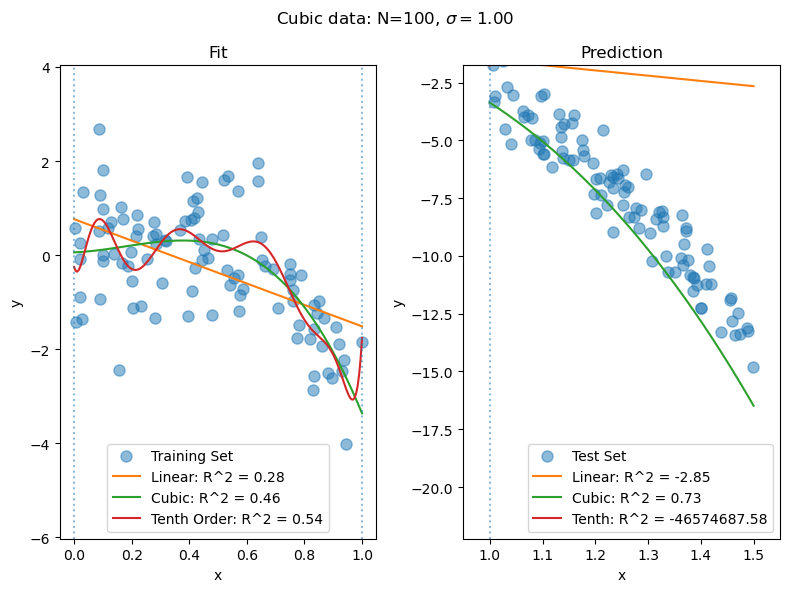

In [118]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(1, 100, 1, 0, 1, 1, 1.5)

### Example 2: Cubic data, small training set, noisy. Prediction range much larger than training range.

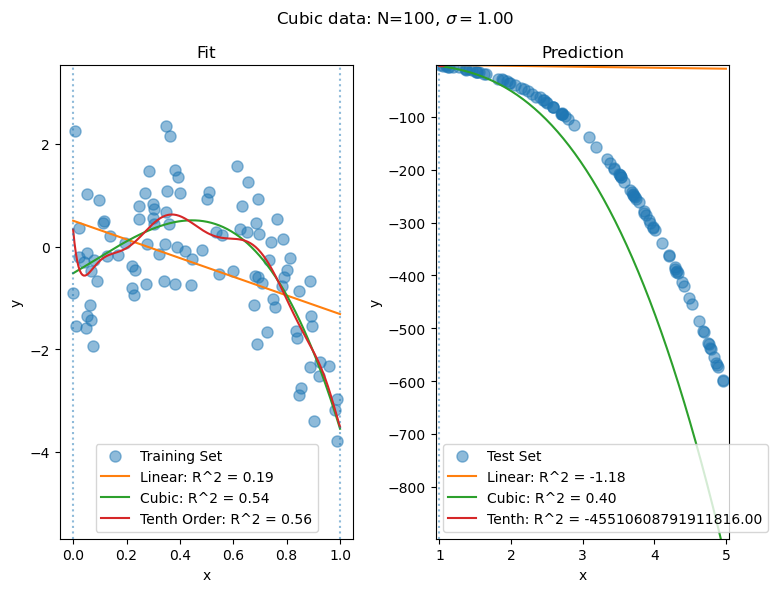

In [117]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(1, 100, 1, 0, 1, 1, 5)

### Example 3: Cubic data, large training set, noisy. Prediction range somewhat larger than training range.

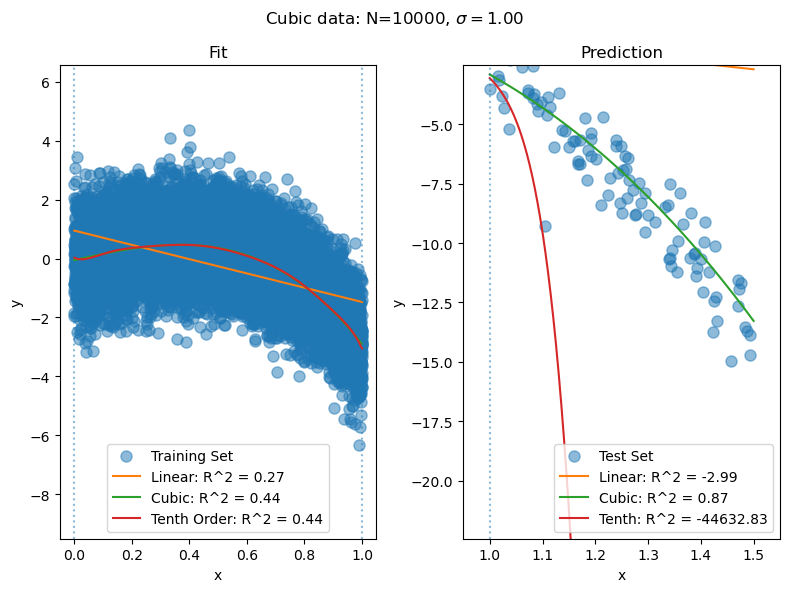

In [98]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(1, 10000, 1, 0, 1, 1, 1.5)

### Example 4: Cubic data, large training set, noisy. Prediction range much larger than training range.

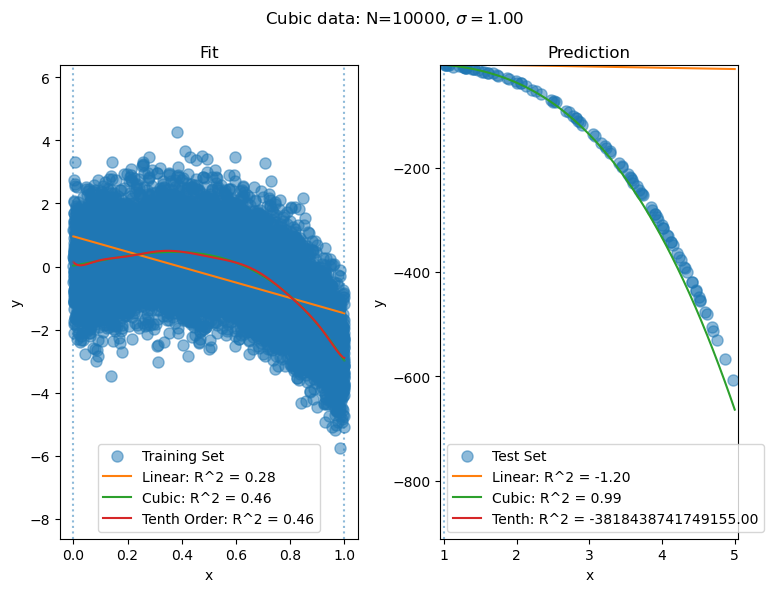

In [99]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(1, 10000, 1, 0, 1, 1, 5)

### Example 5: Cubic data, large training set, noisy. Prediction range much much larger than training range.

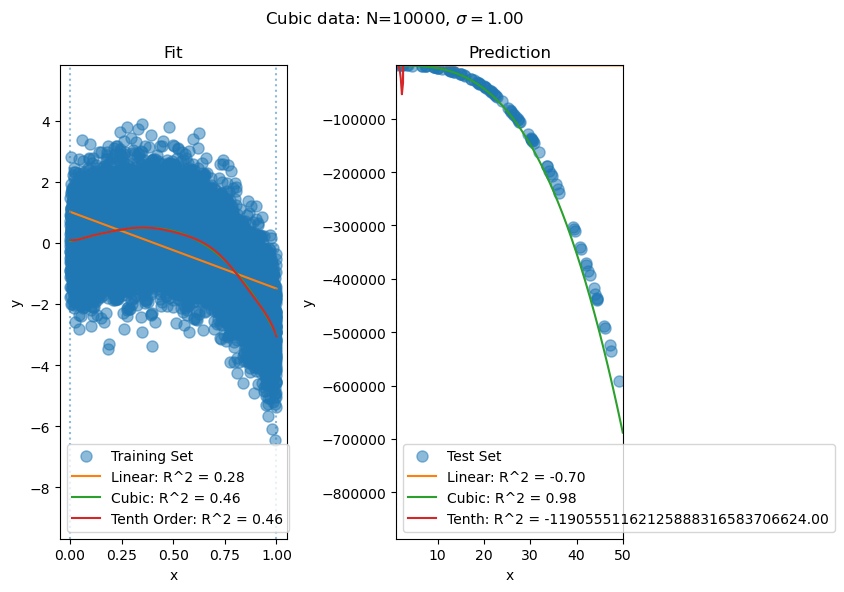

In [105]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(1, 10000, 1, 0, 1, 1, 50)

### Discussion

It can be observed in example 1 that the cubic function can generalize to new data rather well, performing even better than it did at fitting to the training data. The other functions make good fits but don't generalize anywhere nearly as well.

Comparing examples 1 and 2, the cubic function starts to lose some prediction quality the further out we go.

Comparing with examples 3-5, increasing the amount of training data can dramatically improve how far the appropriate model is able to generalize to unfamiliar data.

And obviously inappropriate models won't generalize at all. 

# 2. High Bias: Fitting and predicting when the data is not in the model class

The previous set of examples showed that the choice of model is very important for predictions to generalize. But even when predictions are made on familiar data, the choice of model matters. These examples show the results of applying our models to data that is generated by a cubic function, and then by a tenth order function, focusing on predictions that are made inside of the training set's range. 

### Example 1: Linear data, small training set, noisy.

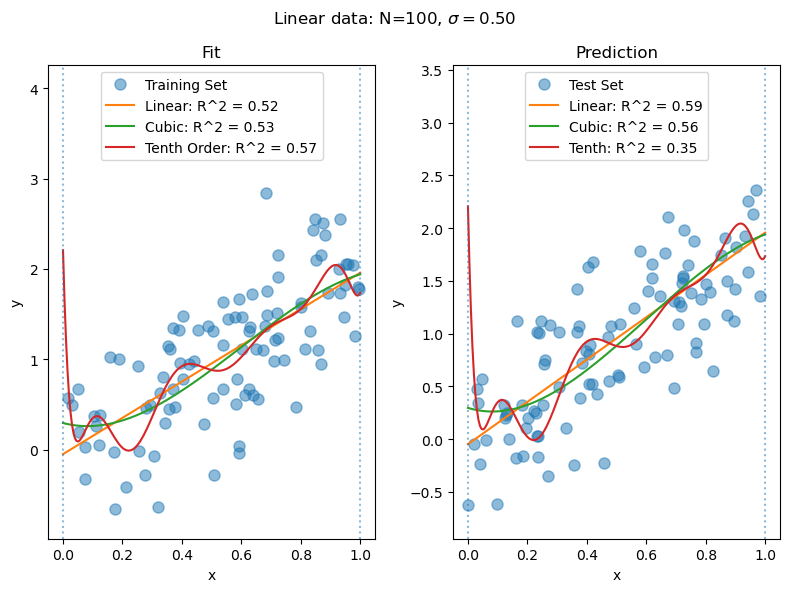

In [119]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(0, 100, 0.5, 0, 1, 0, 1)

### Example 2: Linear data, large training set, noisy.

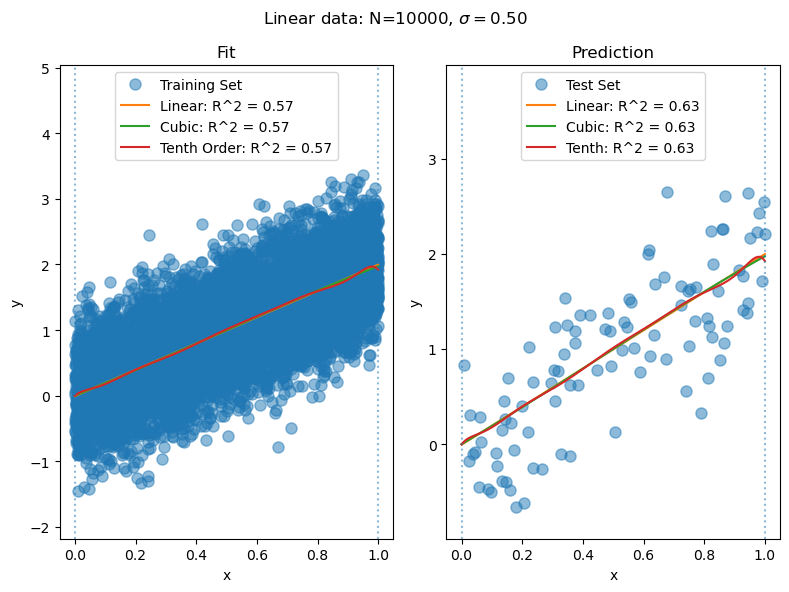

In [120]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(0, 10000, 0.5, 0, 1, 0, 1)

### Example 3: Cubic data, small training set, noisy.

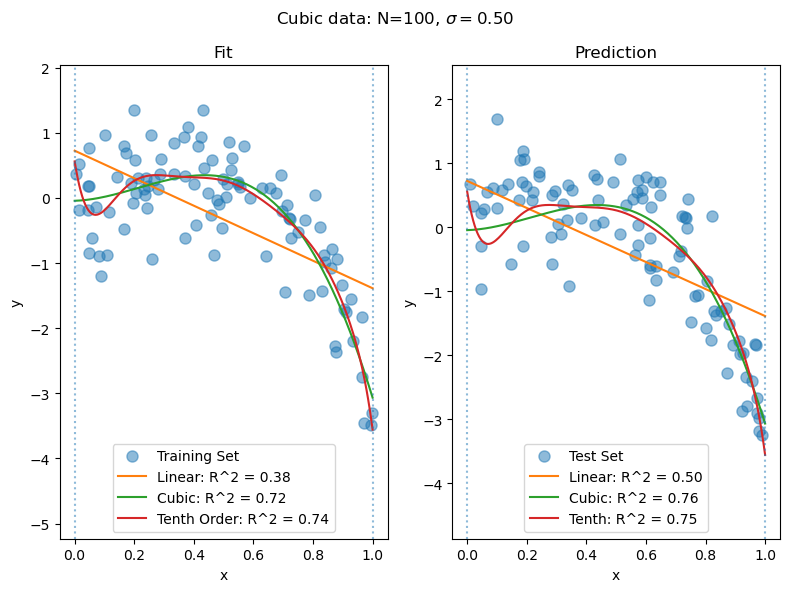

In [106]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(1, 100, 0.5, 0, 1, 0, 1)

### Example 4: Cubic data, large training set, noisy.

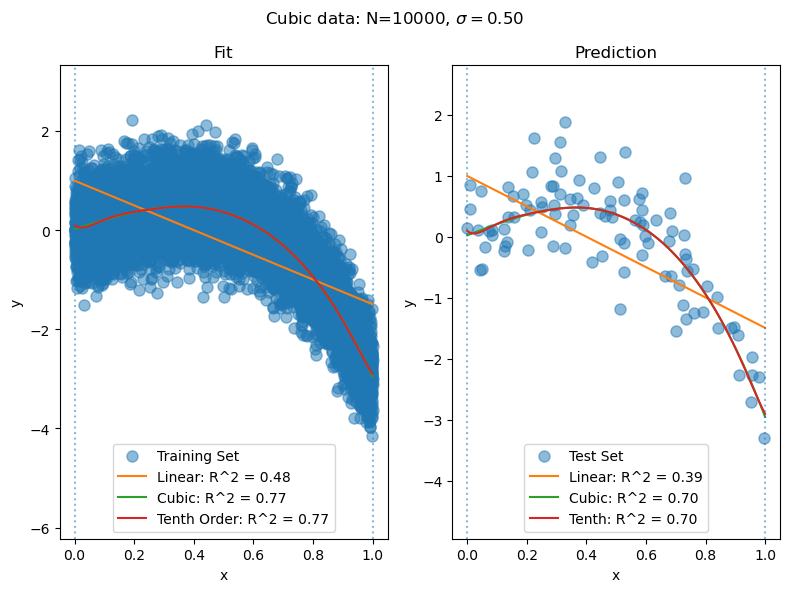

In [107]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(1, 10000, 0.5, 0, 1, 0, 1)

### Example 5: Tenth order data, small training set, noisy.

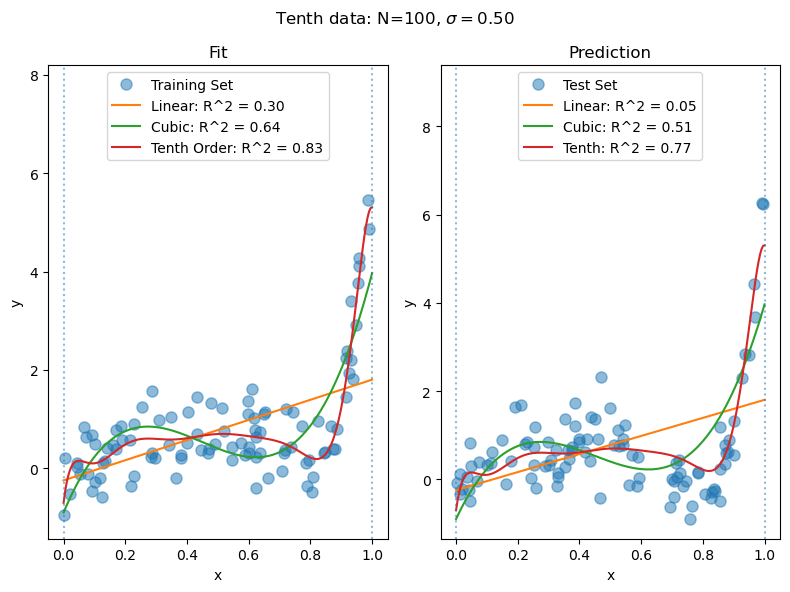

In [108]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(2, 100, 0.5, 0, 1, 0, 1)

### Example 6: Tenth order data, larger training set, noisy.

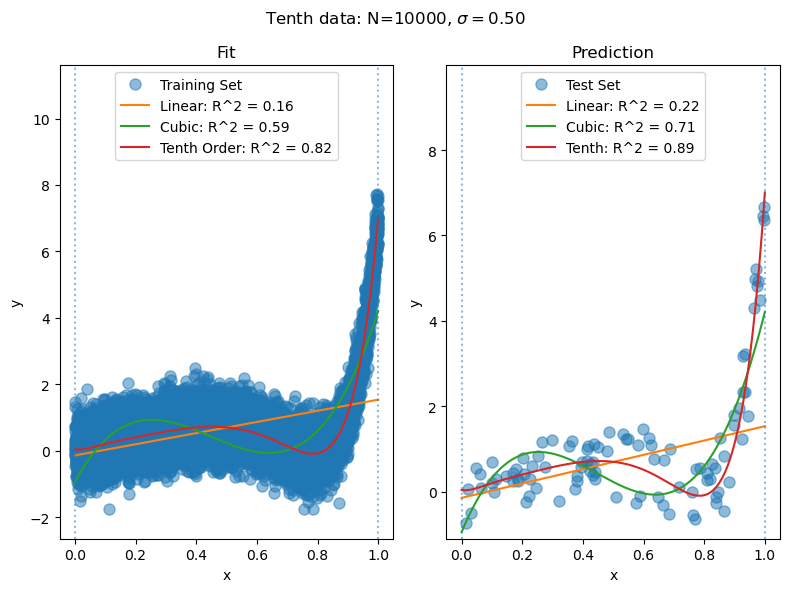

In [109]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(2, 10000, 0.5, 0, 1, 0, 1)

### Discussion:

In the cases of linear data, (examples 1 and 2), it can be observed that all three functions are capable of fitting to the training data and predicting the testing data. The tenth order model shows signs of overfitting, but a higher amount of data resolves this, and they end up all performing equally well. These examples show low bias, because the true data is in the model class of all three functions.

In the cases of cubic data (examples 3 and 4), it can be observed that the linear function does not perform as well as the other two function classes do. Even when the training set size is increased, it performs quite a lot worse at prediction, whereas the other two functions predict just about as well as they did before. These examples show higher bias in the linear model than in the other two models.

These effects are exaggerated in the cases of tenth order data (examples 5 and 6), and replicated in the cubic model to a somewhat lesser extent. When the linear model is given a low amount of training data, it doesn't even predict as well as it fits. 

This shows that the linear and cubic models demonstrate a lot of bias error with respect to data that is far more complicated. Increasing the amount of training data does not improve bias error either - a linear function will never be able to perfectly model higher order data.

# 3. High Variance: Sensitivity of the model to noisy data in the model class

These examples show the results of applying our models to data that is generated by a linear function, as the amount of noise and training data varies. Each choice of parameter will be repeated 3 times to demonstrate variance. We will look at predictions made within and just outside of the training set's range. Performance values can be ignored, instead focus should be on the shapes of the prediction curves.

### Example 1: Linear data, small training set, some noise.

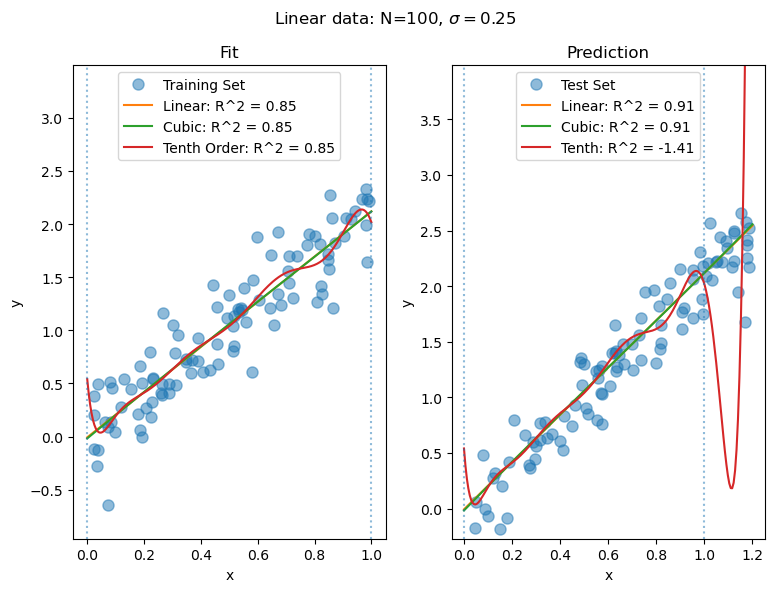

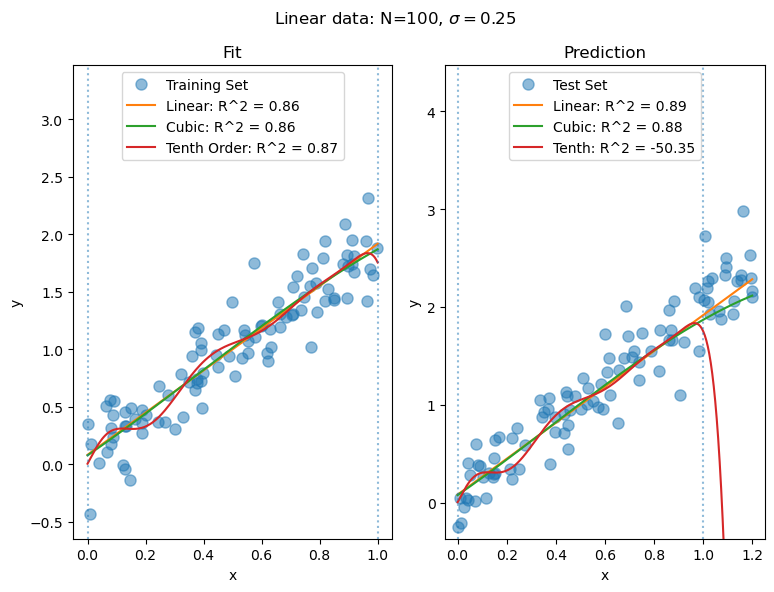

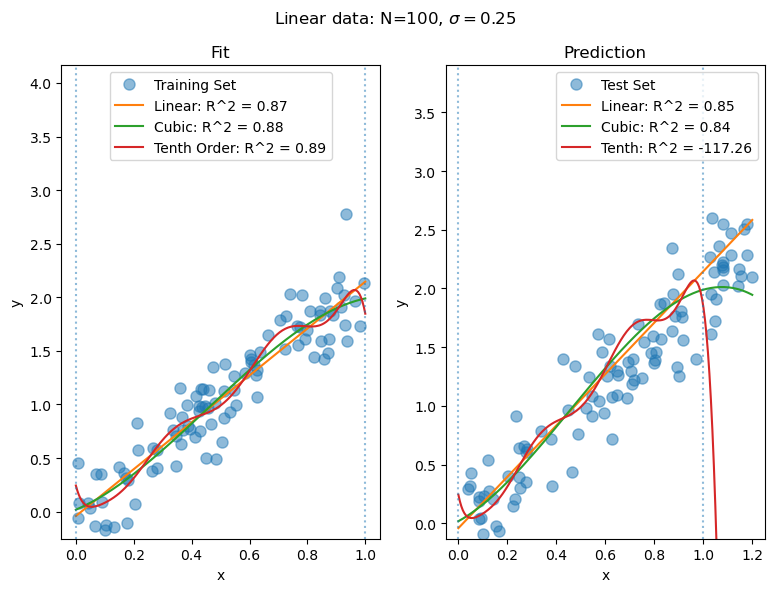

In [110]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(0, 100, 0.25, 0, 1, 0, 1.2)
test_model(0, 100, 0.25, 0, 1, 0, 1.2)
test_model(0, 100, 0.25, 0, 1, 0, 1.2)

### Example 2: Linear data, small training set, large noise.

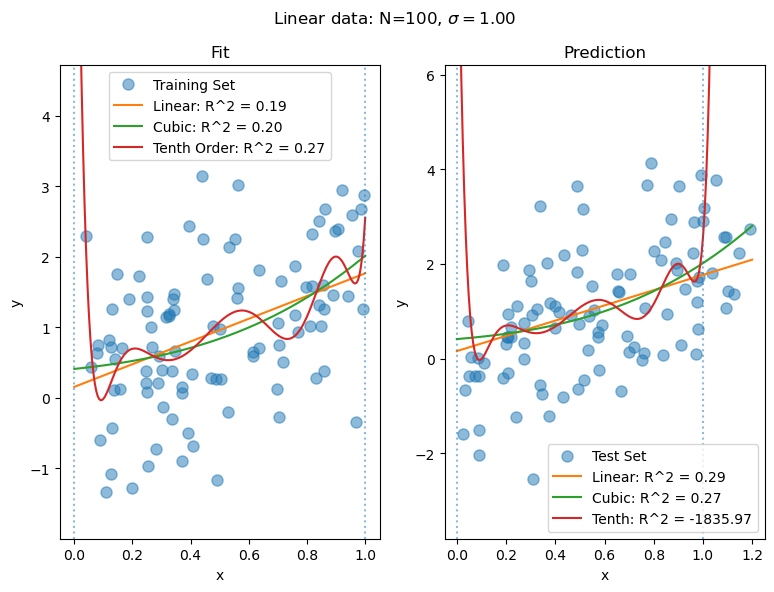

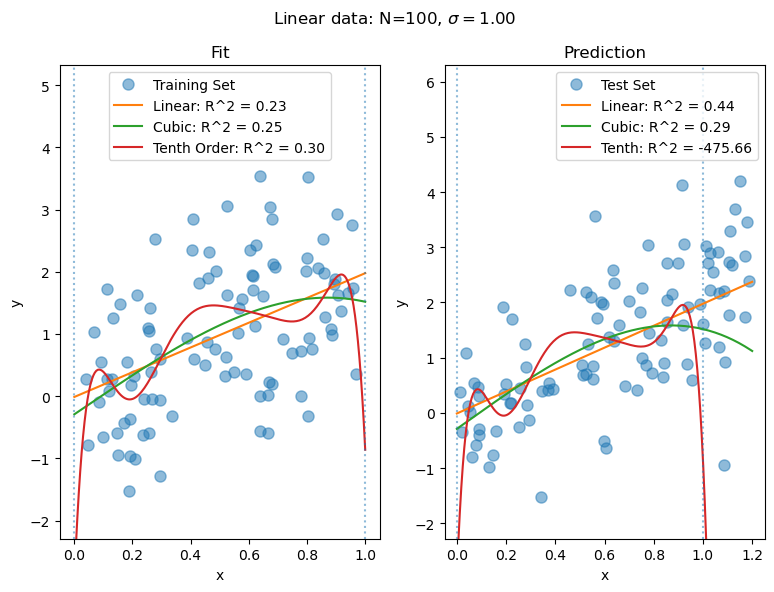

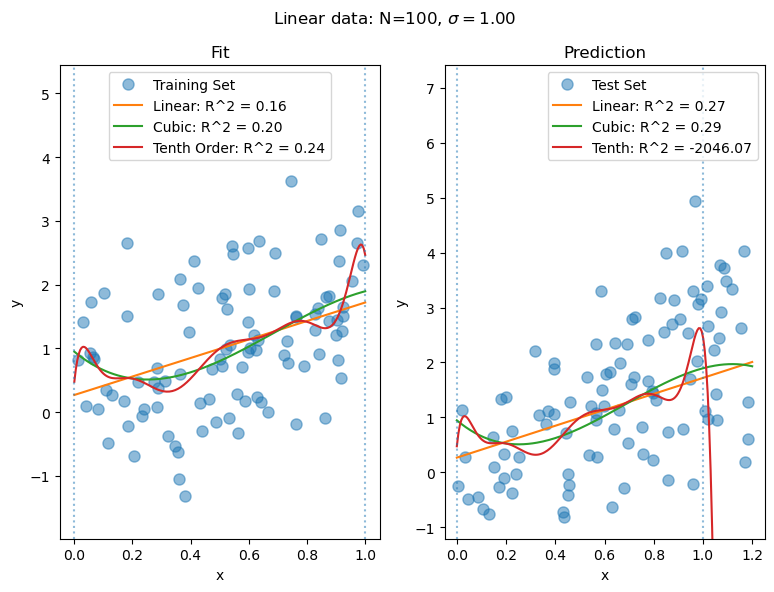

In [111]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(0, 100, 1, 0, 1, 0, 1.2)
test_model(0, 100, 1, 0, 1, 0, 1.2)
test_model(0, 100, 1, 0, 1, 0, 1.2)

### Example 3: Linear data, large training set, some noise.

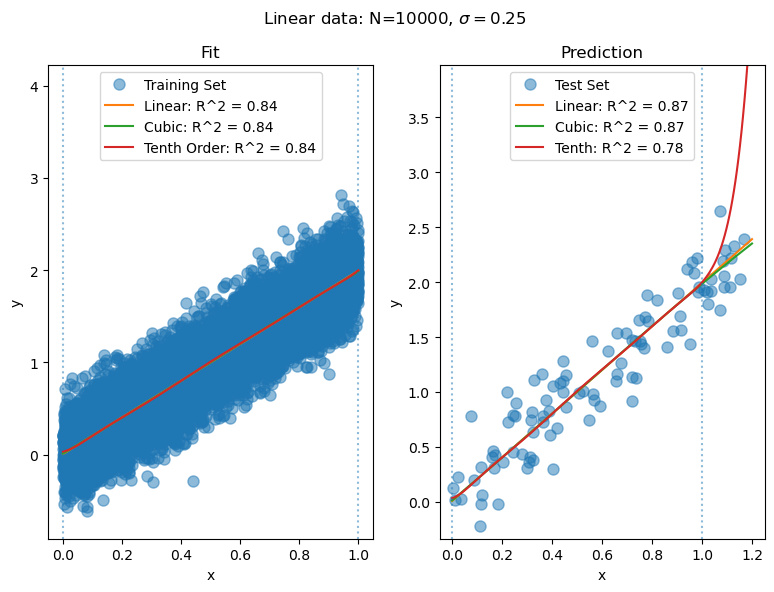

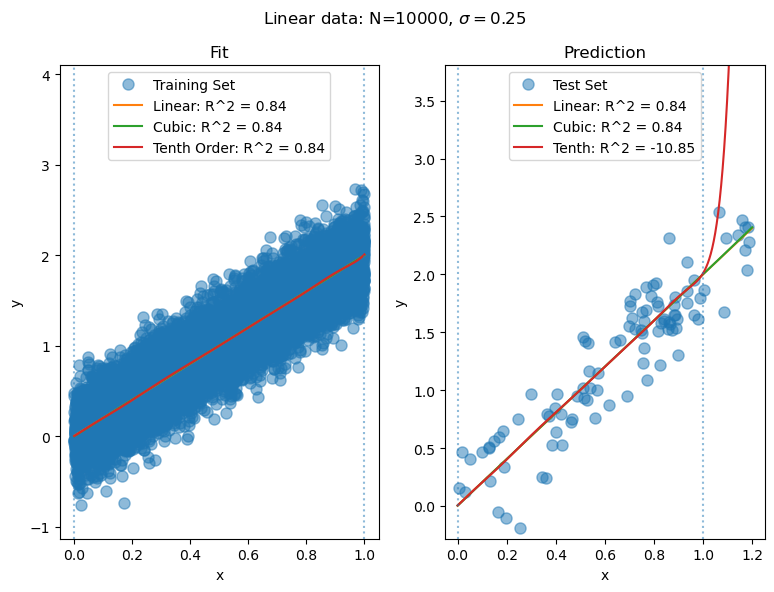

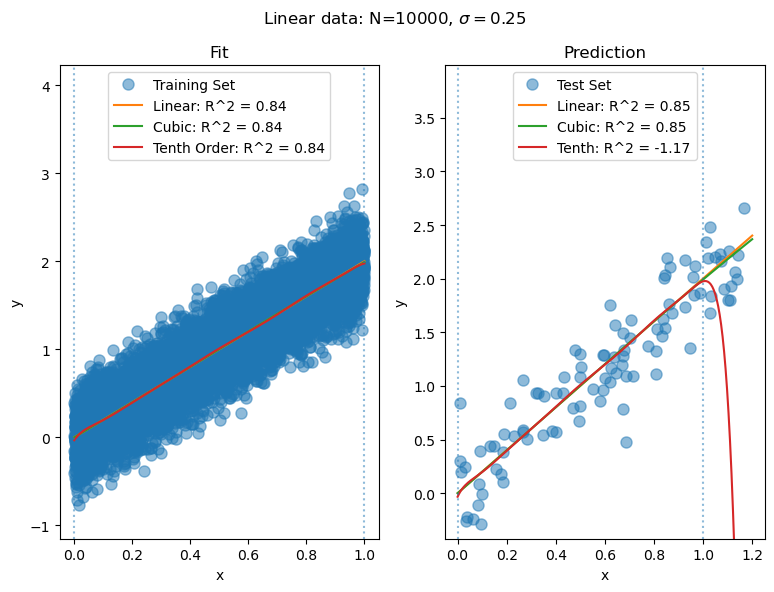

In [112]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(0, 10000, 0.25, 0, 1, 0, 1.2)
test_model(0, 10000, 0.25, 0, 1, 0, 1.2)
test_model(0, 10000, 0.25, 0, 1, 0, 1.2)

### Example 4: Linear data, large training set, large noise.

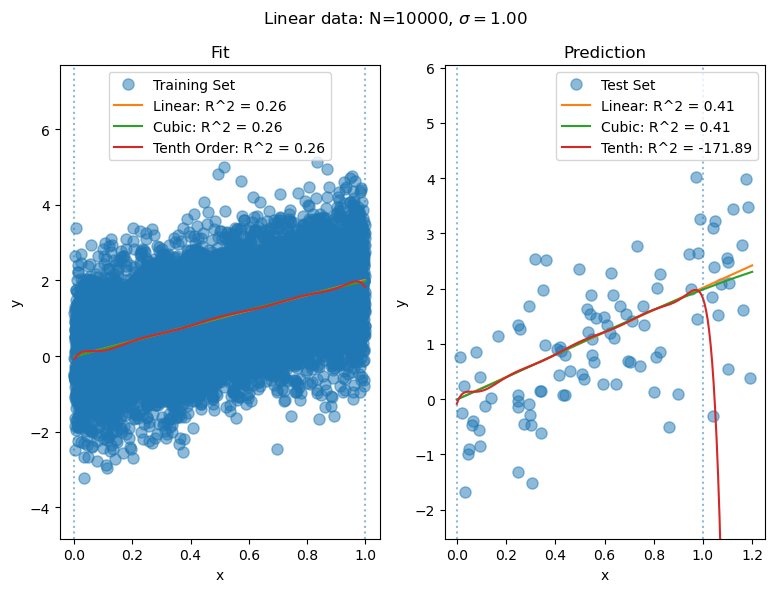

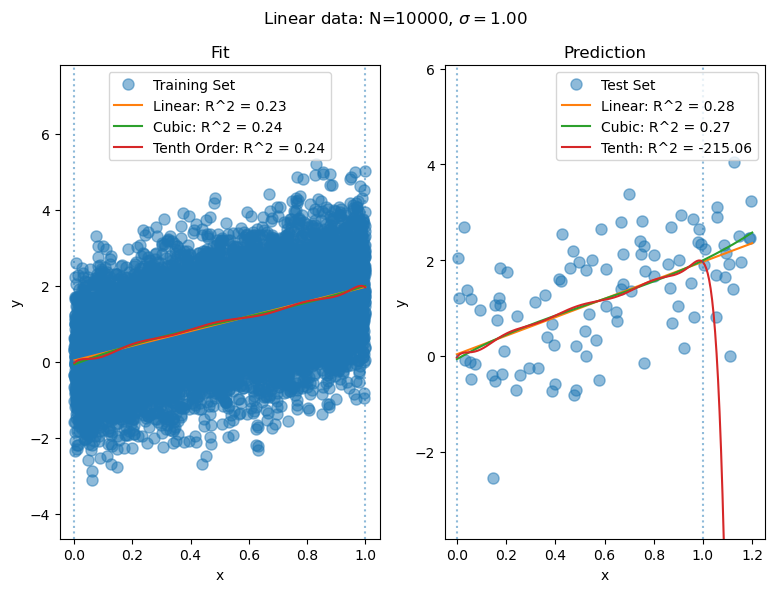

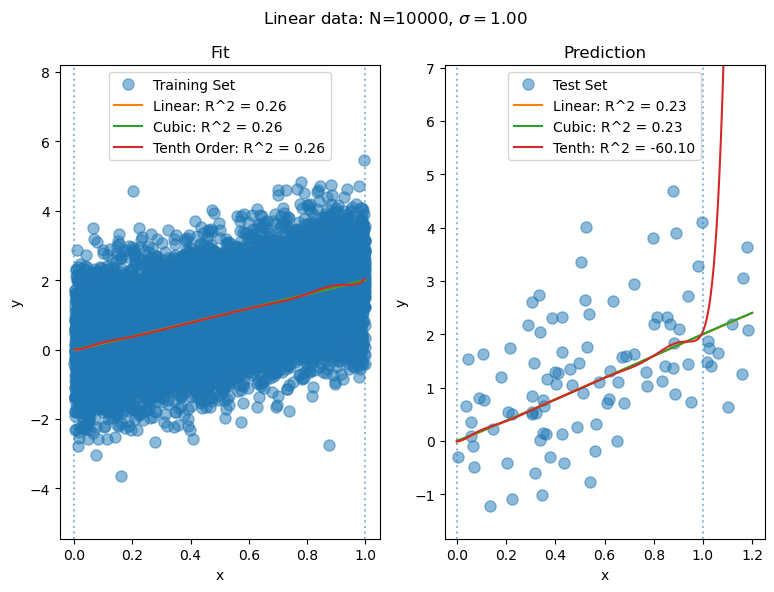

In [113]:
# model_class, N_train, sigma, train_min, train_max, test_min, test_max
test_model(0, 10000, 1, 0, 1, 0, 1.2)
test_model(0, 10000, 1, 0, 1, 0, 1.2)
test_model(0, 10000, 1, 0, 1, 0, 1.2)

### Discussion:

It can be observed in example 2 that the cubic and tenth order models are rather sensitive to different training samples, the tenth order model especially so, and especially in predictions that are outside the range of the training data. 

Comparing examples 2 and 1, reducing the fundamental noise of the data helps stabilize the predictions, but the tenth order function can still have large variance outside of the training set's range.

Examples 3 and 4 show that variance in the predictions is further reduced by increasing the training data size. 

The cubic and tenth order models demonstrate a large amount of variance error. However, these variance errors go away with larger amounts of training data.

# Summary

Models have a certain limit to how far they can generalize to data that doesn't closely match what it was trained on. T

A highly biased model is one that cannot capture all features of the data. High-bias models with too little complexity will underfit. These bias errors can be improved by using models with higher model complexity, but bias error does not go away even with large amounts of training data.

A model has large variance when it is highly sensitive to differences in the training sets. High-variance models will overfit, and these models generally have high model complexity. This is the tradeoff between bias and variance as model complexity increases for finite training sizes. Variance error does go down with increasing amounts of training data.

Data is often limited, expensive to operate on, and usually there's very little we can do about statistical noise in the data itself. This suggests that it might usually be more practical to select a lower variance model with higher bias. But when we are able to work with very large amounts of data, it's better to select a lower bias model with higher variance, and let a large amount of training smooth away the variance. 

It's important to note that model complexity isn't often correlated with the number of parameters in the model, and the analysis in this notebook is more like a heuristic. We probably won't use linear regression to model higher order data. An example of a more realistic application of bias vs variance is adding regularization to models, such as the regularizers in Ridge regression and LASSO. These regularizers intentionally add a little bit of bias to the model in order to decrease variance.
